In [1]:
import netCDF4
import numpy as np
import os
import csv
import datetime
from dateutil.parser import parse
import logging
import matplotlib.pyplot as plt

In [2]:
logger = logging.getLogger("nutrients")
logger.setLevel(logging.DEBUG)
logging.info("Start")

In [3]:
datadir = "/home/ctroupin/Data/Alborex/Nutrient/"
nutrientfile = os.path.join(datadir, "alborex_nutrients.csv")

In [191]:
def check_var(var, val1=-999999., val2=0.0):
    if (var == "n.m."):
        var = val1 
    elif (var == "n.r."):
        var = val1 
    elif var == "<D.L.":
        var = val2
    else:
        var = float(var) 
    
    return var

In [192]:
def process_line(lines):
    # Split line using taba
    lsplit = lines.split("\t")
    nsta, depthtarget, depth, day, hour, lon, lat, nitrogen, nitrate, phosphate = lsplit[:]
    depthtarget = float(depthtarget)
    
    # If measured depth is missing, take the target depth
    if len(depth) == 0:
        depth = depthtarget
    else:
        depth = float(depth)
    
    # Parse time: if hour not recorded, use 00:00 AM
    # (will be changed later)
    if hour == "n.r.":
        hour = "00:00:00 AM"
    ddate = parse(" ".join((day, hour)))
    
    # Coordinates
    lon = check_var(lon)
    lat = check_var(lat)
                    
    # Nutrient variables
    nitrogen = check_var(nitrogen) * 0.001
    nitrate = check_var(nitrate) * 0.001
    phosphate = check_var(phosphate) * 0.001
        
    return nsta, depthtarget, depth, ddate, lon, lat, nitrogen, nitrate, phosphate

In [172]:
station, depths, dates, lonlist, latlist, nitritelist, nitratelist, phosphatelist = \
np.array([]), np.array([]), np.array([]), np.array([]), \
np.array([]), np.array([]), np.array([]), np.array([])

with open(nutrientfile) as f:
    # Read 1st line
    labelline = f.readline()
    logger.debug(labelline.rstrip())
    for ii, lines in enumerate(f.readlines()):
        nsta, depthtarget, depth, ddate, lon, lat, nitrite, nitrate, phosphate = \
        process_line(lines.rstrip())
        
        station = np.append(station, nsta)
        depths = np.append(depths, depth) 
        dates = np.append(dates, ddate)
        lonlist = np.append(lonlist, lon)
        latlist = np.append(latlist, lat)
        nitritelist = np.append(nitritelist, nitrite)
        nitratelist = np.append(nitratelist, nitrate) 
        phosphatelist = np.append(phosphatelist, phosphate)

DEBUG:nutrients:Station	Depth, m	Depth2, m	Date	Hour	Latitude	Longitude	N-NO2-, µM	N-NO3, µM	P-PO4, µM


In [193]:
def nutrients_to_nc(ncfile, stations, lon, lat, depths, dates, NO2, NO3, PO4, 
                    valex=-999.):
    """
    Write the nutrient data into a single netCDF file `ncfile`
    Inputs:
      lon, lat, depths, dates, NO2, NO3, PO4 are numpy arrays
    """

    with netCDF4.Dataset(ncfile, "w", format="NETCDF4") as nc:

        nstations = len(np.unique(station));
        ndepths = 8
        
        # Dimensions
        time = nc.createDimension("time", nstations)         # unlimited
        depth = nc.createDimension("depth", ndepths)

        # Variables and attributes
        time = nc.createVariable("time", "f8",("time",), fill_value=valex)
        time.standard_name = "time"
        time.units = "seconds since 1970-01-01 00:00:00"
        time.axis = "T"
        time.calendar = "gregorian"

        DEPTH = nc.createVariable("DEPTH", "f8",("time", "depth"))
        DEPTH.ancillary_variables = "QC_DEPTH"
        DEPTH.axis = "Z"
        DEPTH.long_name = "Depth coordinate"
        DEPTH.positive = "down"
        DEPTH.reference_datum = "geographical coordinates, WGS84 projection"
        DEPTH.standard_name = "depth"
        DEPTH.units = "m"

        LON = nc.createVariable("LON", "f4",("time",), fill_value=valex)
        LON.standard_name = "longitude"
        LON.long_name = "Longitude"
        LON.units = "degrees_east"
        LON.ancillary_variables = "QC_LON"
        LON.axis = "X"
        LON.valid_min = -180.
        LON.valid_max = 180.
        LON.reference_datum = "geographical coordinates, WGS84 projection" ;

        LAT = nc.createVariable("LAT", "f4",("time",), fill_value=valex)
        LAT.standard_name = "latitude"
        LAT.long_name = "Latitude"
        LAT.units = "degrees_north"
        LAT.ancillary_variables = "QC_LAT"
        LAT.axis = "Y"
        LAT.valid_min = -90.
        LAT.valid_max = 90.
        LAT.reference_datum = "geographical coordinates, WGS84 projection"

        nitrate = nc.createVariable("nitrate", "f8",("time", "depth"), fill_value=valex)
        nitrate.coordinates = "time DEPTH"
        nitrate.long_name = "Sea water nitrate concentration"
        nitrate.observation_type = "measured"
        nitrate.standard_name = "mole_concentration_of_nitrate_in_sea_water"
        nitrate.units = "mol m-3"
        nitrate.ancillary_variables = "QC_nitrate" ;
        
        QC_nitrate = nc.createVariable("nitrate_qc", "b",("time", "depth"), fill_value=valex)
        QC_nitrate.coordinates = "time DEPTH"
        QC_nitrate.long_name = "Quality flag for sea water nitrate concentration"
        
        nitrite = nc.createVariable("nitrite", "f8",("time", "depth"), fill_value=valex)
        nitrite.coordinates = "time DEPTH"
        nitrite.long_name = "Sea water nitrite concentration"
        nitrite.observation_type = "measured"
        nitrite.standard_name = "mole_concentration_of_nitrite_in_sea_water"
        nitrite.units = "mol m-3"
        nitrate.ancillary_variables = "QC_nitrate" ;
            
        QC_nitrite = nc.createVariable("nitrite_qc", "b",("time", "depth"), fill_value=valex)
        QC_nitrite.coordinates = "time DEPTH"
        QC_nitrite.long_name = "Quality flag for sea water nitrite concentration"

        phosphate = nc.createVariable("phosphate", "f8",("time", "depth"), fill_value=valex)
        phosphate.coordinates = "time DEPTH"
        phosphate.long_name = "Sea water phosphate concentration"
        phosphate.observation_type = "measured"
        phosphate.standard_name = "mole_concentration_of_phosphate_in_sea_water"
        phosphate.units = "mol m-3"
        phosphate.ancillary_variables = "QC_phosphate" ;
            
        QC_phosphate = nc.createVariable("phosphate_qc", "b",("time", "depth"), fill_value=valex)
        QC_phosphate.coordinates = "time DEPTH"
        QC_phosphate.long_name = "Quality flag for sea water phosphate concentration"
        
        # Loop on the stations
        for ii, sta in enumerate(np.unique(stations)):
            # logger.debug("Station: {}".format(sta))
            goodlines = np.where(stations == sta)[0]
            # logger.debug(goodlines[0])
            ngood = len(goodlines)
            DEPTH[ii,:ngood] = depths[goodlines]
            nitrate[ii,:ngood] = nitratelist[goodlines]
            nitrite[ii,:ngood] = nitritelist[goodlines]
            phosphate[ii,:ngood] = phosphatelist[goodlines]
            time[ii] = (dates[goodlines[0]] - datetime.datetime(1970, 1, 1)).total_seconds()
            LON[ii] = lonlist[goodlines[0]]
            LAT[ii] = latlist[goodlines[0]]

In [194]:
outputfile = "nutrients.nc"
nutrients_to_nc(outputfile, station, lonlist, latlist, depths, dates, 
                nitritelist, nitratelist, phosphatelist)

## Test: read the newly created netCDF

In [195]:
def test_coordinates(outputfile):
    with netCDF4.Dataset(outputfile) as nc1:
        lon = nc1.variables["LON"][:]
        lat = nc1.variables["LAT"][:]
        dtime = nc1.variables["time"][:]
    lon = np.ma.masked_less(lon, -180.)
    lat = np.ma.masked_less(lat, -90.)
    plt.plot(lon, lat, "ko", markersize=.3)
    plt.scatter(lon, lat, s=5, c=dtime)
    plt.colorbar()
    plt.show()
    plt.close()

In [213]:
def test_dates(outputfile):
    with netCDF4.Dataset(outputfile) as nc1:
        dtime = nc1.variables["time"][:]
        timeunits = nc1.variables["time"].units
    dates = netCDF4.num2date(dtime, timeunits)
    print(dates)

In [214]:
test_dates(outputfile)

[datetime.datetime(2014, 5, 25, 10, 1, 8)
 datetime.datetime(2014, 5, 25, 13, 23, 17)
 datetime.datetime(2014, 5, 26, 6, 29, 7)
 datetime.datetime(2014, 5, 26, 7, 26, 12)
 datetime.datetime(2014, 5, 26, 8, 17, 28)
 datetime.datetime(2014, 5, 26, 9, 2, 24)
 datetime.datetime(2014, 5, 26, 9, 59, 45)
 datetime.datetime(2014, 5, 26, 10, 50, 29)
 datetime.datetime(2014, 5, 26, 11, 39, 40)
 datetime.datetime(2014, 5, 26, 12, 45, 25)
 datetime.datetime(2014, 5, 26, 13, 32, 33)
 datetime.datetime(2014, 5, 26, 14, 33, 25)
 datetime.datetime(2014, 5, 26, 15, 31, 58)
 datetime.datetime(2014, 5, 26, 16, 29, 35)
 datetime.datetime(2014, 5, 26, 17, 16, 15)
 datetime.datetime(2014, 5, 26, 18, 2, 19)
 datetime.datetime(2014, 5, 26, 19, 3, 9)
 datetime.datetime(2014, 5, 26, 19, 47, 28)
 datetime.datetime(2014, 5, 26, 20, 42, 7)
 datetime.datetime(2014, 5, 26, 21, 31, 36)
 datetime.datetime(2014, 5, 26, 22, 18, 43)
 datetime.datetime(2014, 5, 27, 5, 14, 47)
 datetime.datetime(2014, 5, 27, 6, 4, 27)
 dat

In [208]:
def test_profiles(outputfile):
    """
    Make a test plot with all the profiles for nitrate, nitrite and phosphate
    """
    with netCDF4.Dataset(outputfile) as nc1:
        depth = nc1.variables["DEPTH"][:]
        phosphate = nc1.variables["phosphate"][:]
        nitrate = nc1.variables["nitrate"][:]
        nitrite = nc1.variables["nitrite"][:]
    
    # Mask bad values
    nitrite = np.ma.masked_less(nitrite, 0.0)
    phosphate = np.ma.masked_less(phosphate, 0.0)
    nitrate = np.ma.masked_less(nitrate, 0.0)
    
    fig = plt.figure(figsize=(12,8))
    plt.subplot(1,3,1)
    plt.title("Phosphate")
    plt.plot(phosphate.T * 1000., depth.T)
    plt.ylabel("$\mu$ M")
    plt.gca().invert_yaxis()
    plt.subplot(1,3,2)
    plt.title("Nitrate")
    plt.plot(nitrate.T * 1000., depth.T)
    plt.gca().invert_yaxis()
    plt.subplot(1,3,3)
    plt.title("Nitrite")
    plt.plot(nitrite.T * 1000., depth.T)
    plt.gca().invert_yaxis()
    plt.show()
    plt.close()

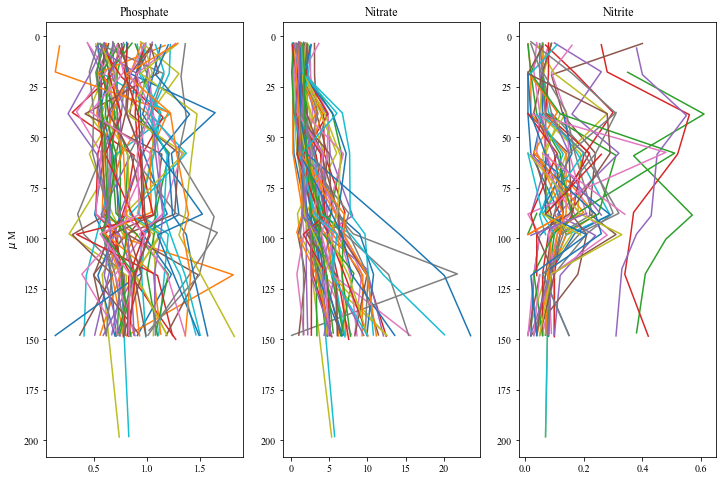

In [209]:
test_profiles(outputfile)

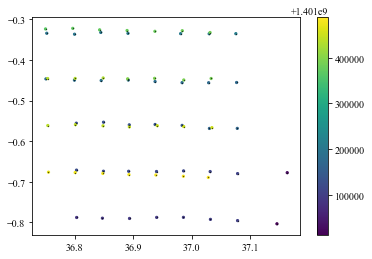

In [187]:
test_coordinates(outputfile)